In [13]:
from collections import Counter
from operator import itemgetter

import numpy as np
import tensorflow as tf

np.random.seed(0)

def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [14]:
NUM_EPOCHS = 20
BATCH_SIZE = 2

In [15]:
# Subsample the data
data = sample_data()
mask = range(int(data.shape[0]*0.8), data.shape[0])
data_val = data[mask]
mask = range(int(data.shape[0]*0.8))
data_train = data[mask]

In [16]:
theta = tf.Variable(tf.zeros(100), dtype=tf.float32, name='theta')

@tf.function
def p(x):
    N = tf.cast(tf.shape(x)[0], tf.int64)
    softmax = tf.ones([N, 1]) * tf.math.softmax(theta)
    idx_x = tf.stack([tf.range(N, dtype=tf.int64), x-1], axis=1)
    return tf.gather_nd(softmax, idx_x)

@tf.function
def softmaxLoss(x):
    return tf.reduce_mean(-tf.math.log(p(x)))

In [17]:
train_dset = tf.data.Dataset.from_tensor_slices(data_train).\
                                repeat(1).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices(data_val).\
                                    batch(BATCH_SIZE)

In [18]:
# Create the metrics
loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
train_loss_history = []
val_loss_history = []
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        log_loss = softmaxLoss(inputs)
    gradients = tape.gradient(log_loss,[theta])
    optimizer.apply_gradients(zip(gradients, [theta]))
    # Update the metrics
    loss_metric.update_state(log_loss)
 

@tf.function
def val_step(inputs):
    log_loss = softmaxLoss(inputs)
    
    # Update the metrics
    val_loss_metric.update_state(log_loss)


for epoch in range(NUM_EPOCHS):
    # Reset the metrics
    loss_metric.reset_states()
    train_dset = train_dset.shuffle(buffer_size=10000)
    for inputs in train_dset:
        train_step(inputs)
        
    # Repeat the same process for val set
    val_loss_metric.reset_states()
    for inputs in val_dset:
        val_step(inputs)
    # Get the metric results
    mean_loss = loss_metric.result()
    mean_val_loss = val_loss_metric.result()
    train_loss_history.append(mean_loss)
    val_loss_history.append(mean_val_loss)

    print('Epoch: ', epoch)
    print('  train loss:     {:.3f}'.format(mean_loss))
    print('  val loss: {:.3f}'.format(mean_val_loss))

Epoch:  0
  train loss:     4.306
  val loss: 4.148
Epoch:  1
  train loss:     4.104
  val loss: 4.067
Epoch:  2
  train loss:     4.061
  val loss: 4.045
Epoch:  3
  train loss:     4.049
  val loss: 4.038
Epoch:  4
  train loss:     4.044
  val loss: 4.035
Epoch:  5
  train loss:     4.042
  val loss: 4.034
Epoch:  6
  train loss:     4.041
  val loss: 4.033
Epoch:  7
  train loss:     4.041
  val loss: 4.032
Epoch:  8
  train loss:     4.041
  val loss: 4.032
Epoch:  9
  train loss:     4.040
  val loss: 4.032
Epoch:  10
  train loss:     4.040
  val loss: 4.032
Epoch:  11
  train loss:     4.040
  val loss: 4.032
Epoch:  12
  train loss:     4.040
  val loss: 4.033
Epoch:  13
  train loss:     4.041
  val loss: 4.033
Epoch:  14
  train loss:     4.040
  val loss: 4.033
Epoch:  15
  train loss:     4.040
  val loss: 4.033
Epoch:  16
  train loss:     4.041
  val loss: 4.033
Epoch:  17
  train loss:     4.041
  val loss: 4.033
Epoch:  18
  train loss:     4.041
  val loss: 4.033
Epo

In [19]:
prob = []
for i in range(1,101):
    prob.append(p(np.array([i])).numpy()[0])

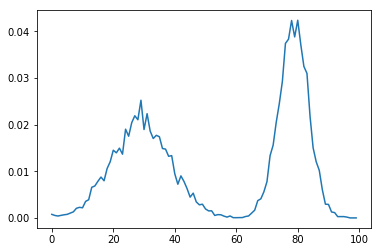

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(prob)

# Plot train/val loss

In [21]:
def plot_training_history(title, label, val_history, train_history, train_marker='.', val_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    train_plots = train_history
    val_plots = val_history
    num_train = len(train_plots)
    for i in range(num_train):
        label='train_loss'
        if labels is not None:
            label += str(labels[i])
        plt.plot(train_plots[i], train_marker, label=label)
    label='val_loss'
    if labels is not None:
        label += str(labels[0])
    plt.plot(val_plots, val_marker, label=label)
    plt.legend(loc='lower center', ncol=num_train+1) 

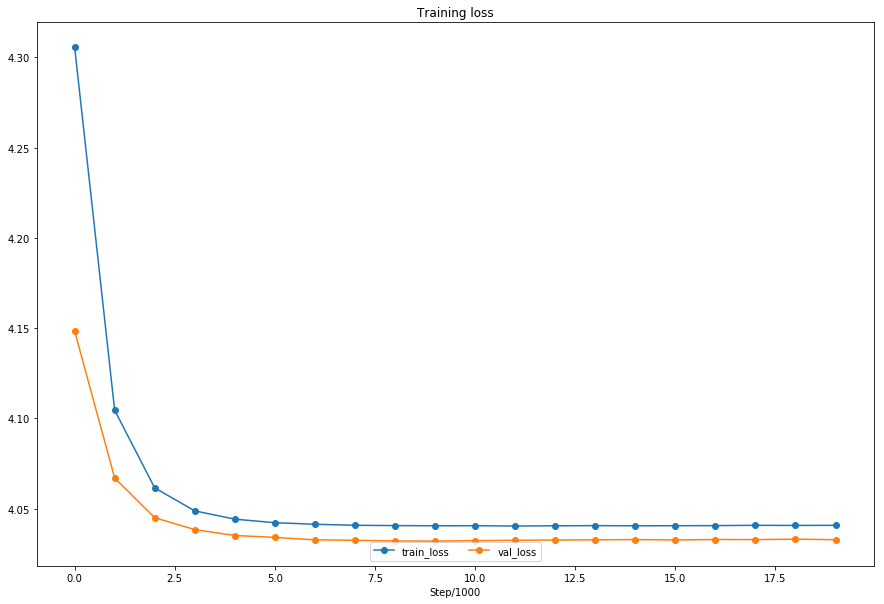

In [22]:
plot_training_history('Training loss','Step/1000', val_loss_history, [train_loss_history], 
                     train_marker='-o', val_marker='-o')
plt.gcf().set_size_inches(15, 10)
plt.show()